In [1]:
import torch
from torch import nn as nn
from torch.distributions import Normal, multivariate_normal
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.autograd import Variable
import collections
from typing import Iterable
import scipy.sparse as sp_sparse
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from tqdm import trange
from tqdm import tqdm
import sys

import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F
import scanpy as sc
from Generate_data import *
from tensorboardX import SummaryWriter
writer = SummaryWriter('log')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cpu")

In [4]:
batch_size = 20
epochs = 30
X_dim = 20
n_sample = 2000

In [5]:
class Dataset_Sim(Dataset):
    def __init__(self, Expression_Matrix):
        """
        :param Expression_Matrix: a numpy array save the expression matrix
        """
        self.Expression_Matrix = Expression_Matrix

    def __len__(self):
        return self.Expression_Matrix.shape[0]

    def __getitem__(self, item):
        return self.Expression_Matrix[item]

In [6]:
class VAE(nn.Module):
    def __init__(self, input_size=10, h_dim=100, z_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, input_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size(), device = device)
       
        z = mu + std * esp
#         print('mu = ', mu)
#         print('logvar =  ', logvar)
#         print('esp = ', esp)
#         print('std = ', std)
#         print('z = ', z)
        return z
    def encoder_function(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
        
    def forward(self, x):
        mu, logvar = self.encoder_function(x)
        z = self.reparameterize(mu, logvar)
#         print(z)
#         print(self.decoder(z))
        return self.decoder(z), mu, logvar

In [7]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [8]:
vae = VAE(input_size=X_dim)
# if torch.cuda.is_available():
#     vae.cuda()
vae.to(device)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=100, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): Sigmoid()
  )
)

In [9]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [10]:
sim1 = Generate_X(X_dim)
sim1.generate([3,5],[n_sample,n_sample], same_mean = False, same_sigma = False)


In [11]:
sample_size = np.repeat(2*n_sample,1)
sample_indices = sim_sample_indices(sample_size)
#print(sample_indices)

In [12]:
sim1.X = (sim1.X - np.average(sim1.X)) / np.std(sim1.X)

In [13]:
data_loader = torch.utils.data.DataLoader(Dataset_Sim(sim1.X), batch_size=batch_size, shuffle=True)

In [14]:
for epoch in range(epochs):
    for idx, X in enumerate(data_loader):
        X = X.float()
        recon_X, mu, logvar = vae(X)
        loss = loss_fn(recon_X, X, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data/batch_size))

Epoch[1/30] Loss: -18.914
Epoch[2/30] Loss: -163.283
Epoch[3/30] Loss: -129.738
Epoch[4/30] Loss: -144.809
Epoch[5/30] Loss: -180.939
Epoch[6/30] Loss: -277.241
Epoch[7/30] Loss: -240.709
Epoch[8/30] Loss: -241.946
Epoch[9/30] Loss: -245.651
Epoch[10/30] Loss: -203.836
Epoch[11/30] Loss: -252.697
Epoch[12/30] Loss: -210.872
Epoch[13/30] Loss: -150.391
Epoch[14/30] Loss: -169.797
Epoch[15/30] Loss: -132.617
Epoch[16/30] Loss: -199.336
Epoch[17/30] Loss: -196.881
Epoch[18/30] Loss: -211.051
Epoch[19/30] Loss: -134.282
Epoch[20/30] Loss: -233.789
Epoch[21/30] Loss: -137.546
Epoch[22/30] Loss: -166.159
Epoch[23/30] Loss: -195.509
Epoch[24/30] Loss: -226.931
Epoch[25/30] Loss: -227.359
Epoch[26/30] Loss: -179.349
Epoch[27/30] Loss: -153.162
Epoch[28/30] Loss: -171.738
Epoch[29/30] Loss: -149.211
Epoch[30/30] Loss: -180.410


In [15]:
trainloader_new = torch.utils.data.DataLoader(Dataset_Sim(sim1.X), batch_size=sim1.X.shape[0], shuffle=False)
dataiter = iter(trainloader_new)
X = dataiter.next()
X = X.float()

In [16]:
mean, logvar  = vae.encoder_function(X)
z = vae.reparameterize(mean, logvar)
x_new = vae.decoder(z)

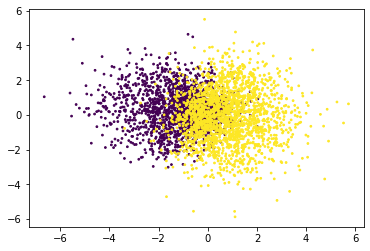

In [17]:
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy(), c = sim1.ct_label[0:sim1.X.shape[0]], s = [3]*len(z))
# plt.savefig('./figures/vae.7242019.3000.png')

In [18]:
np.savetxt('./write/simulation', sim1.X, delimiter = ',')

In [19]:
adata = sc.read_csv('./write/simulation')

In [20]:
adata.obs['cell type'] = sim1.ct_label
adata.obs['batch'] = sample_indices

In [ ]:
sc.pp.neighbors(adata, n_neighbors = 15, metric = 'euclidean', random_state = None)
sc.tl.umap(adata, min_dist = 0.1)

In [ ]:
sc.pl.umap(adata, color = 'cell type')

In [ ]:
sc.tl.pca(adata)

In [ ]:
sc.pl.pca(adata, color = 'cell type')

In [ ]:
sc.tl.tsne(adata)

In [ ]:
sc.pl.tsne(adata, color = 'cell type')